In [ ]:
import pandas as pd
import docker
# make sure you have docker running
client = docker.from_env()
import os
import json
from nlputils import utils
from nlputils.components.axaserver import axaprocessor,axasplitter

In [ ]:
###### Declare the variables #######

path_to_files_list = "path to files from list from **load_docs.ipynb**"

path_to_save_output_from_parsr = "path where the output from axaparsr needs to save the files"

# yuo need to copy the axaparsr container id from the docker
container_id= "cvcvcvc....."


In [4]:
# read the files dataframe
df_pdf = pd.read_json(path_to_files_list)\
                    .query('ImagePDF.notna() & ImagePDF==False').reset_index(drop=True)
df_pdf['pdf_path'] = df_pdf.apply(lambda x: x['orig_filepath'] if x['filetype'] == 'pdf' 
                                  else x['converted_filepath'],axis=1)
df_pdf = df_pdf[df_pdf.pdf_path.notna()]\
                    .sort_values(by = 'page_count',ascending=True)\
                    .reset_index(drop=True)
print("normal pdf files to be processed:",len(df_pdf))

# keeping image pdf as separate dataframe
df_imagepdf = pd.read_json(path_to_files_list)\
                    .query('ImagePDF.notna() & ImagePDF==True').reset_index(drop=True)
df_imagepdf['pdf_path'] = df_imagepdf.apply(lambda x: x['orig_filepath'] if x['filetype'] == 'pdf' 
                                  else x['converted_filepath'],axis=1)
df_imagepdf = df_imagepdf[df_imagepdf.pdf_path.notna()]\
                    .sort_values(by = 'page_count',ascending=True)\
                    .reset_index(drop=True)
print("image pdf files to be processed:",len(df_imagepdf))

normal pdf files to be processed: 642
image pdf files to be processed: 13


## Document Processing

Sort the files with page count: (it takes roughly 1 min for 10 pages on single core)

In [4]:
# get the batches, for more info read doc_string
batches = axaprocessor.create_axa_batches(df_pdf)

In [ ]:
# based on batch type cretaed earlier iterate through them and save 
# the output in folder "../../../batch_type/"
for batch,val in batches.items():
    # if processed_files.json exists for the batch type then it means that the batch type 
    # has been procssed already so skip it
    if os.path.isfile(path_to_save_output_from_parsr + f"{batch}/processed_files.json"):
        print(batch, "completed")
    else:
        print(batch, "not completed")
        print(f"running {batch} for batch params size:{val[1]}, wait_time:{val[2]}, config:{val[3]}")
        # instantiate class object and pass the files list
        if batch != 'verylarge':
            ###### You need to
            batch_test= axaprocessor.axaBatchProcessingLocal(container_id=container_id,
                                        config=val[3],batch_files=val[0].pdf_path.tolist())

            # you can reset the batch parameters, depending on memeory and number of cores that docker has access to
            batch_test.set_batch_params(batch_size=val[1],batch_wait_time=val[2])
        else:
            # for verylarge batch better to use the dynamic wait time
            batch_test= axaprocessor.axaBatchProcessingLocal(container_id=container_id,
                                        config=val[3],batch_files=val[0].pdf_path.tolist())
            batch_test.set_batch_params(batch_size=val[1],dynamic_wait_time=True)

        # call the processing method of class to start the document processings    
        tmp = batch_test.processing(path_to_save_output_from_parsr +f"{batch}/")
        # save the dataframe which contains metadata on processed files
        jsonfile = tmp.to_json(orient="records")
        parsed = json.loads(jsonfile)
        with open( path_to_save_output_from_parsr +f"{batch}/processed_files.json", 'w') as file:
            json.dump(parsed, file, indent=4)      

verysmall completed
small completed
medium completed
large completed
verylarge completed


In [ ]:
# collect the processed files info
batch_types = ['verysmall','small','medium','large','verylarge']
df_pdf = pd.concat([pd.read_json(path_to_save_output_from_parsr + f"{batch}/processed_files.json") 
                                            for batch in batch_types],ignore_index=True)
not_processed_pdf = df_pdf[df_pdf.simple_json_download_successful ==False][['filename','file_path']]\
                                    .reset_index(drop=True)

# process them once again with diiferent dynamic_multiplier than default value
batch_test= axaprocessor.axaBatchProcessingLocal(container_id=container_id,
                                        config='largepdf',batch_files=not_processed_pdf.file_path.tolist())
batch_test.set_batch_params(batch_size=2,dynamic_wait_time=True,dynamic_multiplier=6)
tmp = batch_test.processing(path_to_save_output_from_parsr +"round2/")

jsonfile = tmp.to_json(orient="records")
parsed = json.loads(jsonfile)
with open( path_to_save_output_from_parsr +"round2/processed_files.json", 'w') as file:
    json.dump(parsed, file, indent=4)

Process ImagePDF's

In [ ]:
# instantiate class object and pass the files list
batch_test= axaprocessor.axaBatchProcessingLocal(container_id=container_id,
                                                 batch_files=df_imagepdf.pdf_path.tolist(), config='ocr')
# set the batch parameters, depending on memeory and number of cores that docker has access to
batch_test.set_batch_params(batch_size=2, dynamic_wait_time=True,dynamic_multiplier=10)
tmp = batch_test.processing(path_to_save_output_from_parsr+"imagepdf/")
jsonfile = tmp.to_json(orient="records")
parsed = json.loads(jsonfile)
with open( path_to_save_output_from_parsr +"imagepdf/processed_files.json", 'w') as file:
    json.dump(parsed, file, indent=4)

## Chunking

In [81]:
# collect all the processed docs
folder_name = ['verysmall','small','medium','large','verylarge', 'round2','imagepdf']
df = pd.concat([pd.read_json(path_to_save_output_from_parsr + f"{batch}/processed_files.json") 
                                            for batch in folder_name],ignore_index=True)

In [83]:
def create_save_chunks(filename,path_to_docs):
    # create chunks
    chunks = axasplitter.simplejson_splitter(json_filepath=path_to_docs + os.path.splitext(filename)[0]+'.simple.json',
                                             filename = os.path.splitext(filename)[0],page_start=0,
                                             headings_level=2,lower_threshold=50, upper_threshold=50)
    # save chunks
    with open(path_to_docs+os.path.splitext(filename)[0]+'.chunks.json', 'w') as file:
        json.dump(chunks, file)
    # return chunks filepath
    return path_to_docs+ os.path.splitext(filename)[0] +'.chunks.json'

In [84]:
df['chunks_filepath'] = df.progress_apply(lambda x: create_save_chunks(x['filename'],x['path_to_docs']) 
                                            if x['simple_json_download_successful'] else None,axis=1)

100%|██████████| 689/689 [01:26<00:00,  7.92it/s]


In [85]:
import json
jsonfile = df.to_json(orient="records")
parsed = json.loads(jsonfile)
with open(path_to_save_output_from_parsr +"processed_chunks.json", 'w') as file:
    json.dump(parsed, file, indent=4)

# Quality check

We will perform a brief quality check on the quality of data, both at page level and then at chunks level

In [86]:
# read the chunks metadata file
df = pd.read_json(path_to_save_output_from_parsr +"processed_chunks.json")
df = df[df.simple_json_download_successful ==True].reset_index(drop=True)

In [ ]:
# Performing page level checks

# read raw text page wise using axaprocessor
df['pages'] = df.progress_apply(lambda x: axaprocessor.get_pagewise_text(x['path_to_docs'] + 
                                os.path.splitext(x['filename'])[0]+'.simple.json'),axis=1)

# check for text quality page wise
def check_pages(pages):
    page_check= []
    for page in pages:
        # using gibberish function to detect quality
        page_check.append(utils.is_gibberish(page['content']))
    return page_check

df['gibberish_page_check'] = df.pages.progress_apply(lambda x: check_pages(x))
df['extracted_page_count'] = df.gibberish_page_check.apply(lambda x: len(x))
df = df[df.extracted_page_count != 0].reset_index(drop=True)

df['gibberish_doc_percent'] = df.gibberish_page_check.progress_apply(lambda x: round((sum(x)/len(x)),2))
# checking files percent based on percentage of pages good
# usually from the experience its seen its a good benchmark
# reason for .35 thres is from fact that if document is only 3 pages and of these 1 page is not good 
# its better to check.
print("Total Number of okay files:", len(df[df.gibberish_doc_percent <= 0.35]))

100%|██████████| 648/648 [00:00<?, ?it/s]

Total Number of okay files: 616


Total docs having atleast 1 page classified as gibberish: 106


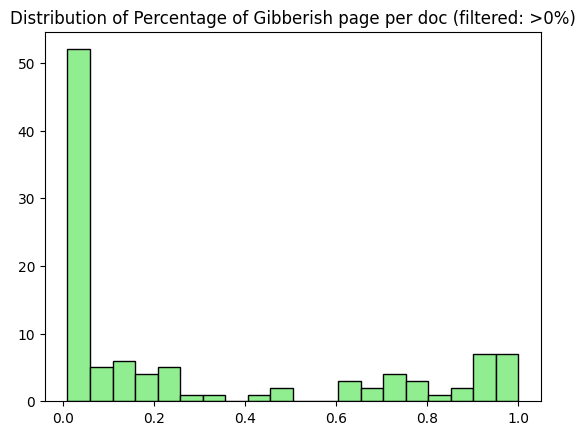

In [88]:
import matplotlib.pyplot as plt

# plot to see the distribution of documents which have atleast one page being classified as gibberish
df['gibberish_page_count'] = df.gibberish_page_check.apply(lambda x: sum(x))
print("Total docs having atleast 1 page classified as gibberish:", len(df.query('gibberish_doc_percent > 0')))
plt.hist(df.query('gibberish_doc_percent > 0').gibberish_doc_percent, color='lightgreen', ec='black', bins=20)
plt.title("Distribution of Percentage of Gibberish page per doc (filtered: >0%)")
plt.show()

Perform some random manual checks on the documents to asses the quality

In [104]:
# # this code block can be sued o filter soem documents which can be used for spot check
# # reason for .35 thres is from fact that if document is only 3 pages and of these 1 page is not good 
# # its better to check.

##### uncomment below and use #########
# to_be_checked = df.query('gibberish_doc_percent > 0')\
#                             .query('gibberish_doc_percent <=0.35')\
#                             .reset_index()

# to_be_checked['checklist'] = to_be_checked.gibberish_page_check.apply(lambda x: [
#                                                         i for i,j in enumerate(x) if j])

# # drop where its only first page
# to_be_checked['check'] = to_be_checked.checklist.apply(lambda x: False if (len(x) ==1) and (x[0]==0) else True)
# to_be_checked = to_be_checked[to_be_checked.check==True].drop(columns=['gibberish_page_check',
#                                                         'check']).reset_index(drop=True)
# to_be_checked.to_csv('manual_check.csv', index=False)
# to_be_checked

In [ ]:
# performing the same quality check on paragraph/chunks level
def check_chunks(filepath):
    with open(filepath) as file:
        chunks  =  json.load(file)
    
    chunks = chunks['paragraphs']
    if len(chunks)!= 0:
        chunks = pd.DataFrame(chunks)
        chunks['check'] = chunks.content.apply(lambda x: utils.is_gibberish(str(x)))
    return list(chunks.check)

df['gibberish_chunk_check'] = df.chunks_filepath.progress_apply(lambda x: check_chunks(x))
df['chunks_count'] = df.gibberish_chunk_check.apply(lambda x: len(x))
df['gibberish_chunks_percent'] = df.gibberish_chunk_check.apply(lambda x: round((sum(x)/len(x)),2))
df['gibberish_chunks_count'] = df.gibberish_chunk_check.apply(lambda x: sum(x))

100%|██████████| 648/648 [00:16<00:00, 39.39it/s]


Total docs having atleast 5 percentage of  chunk classified as gibberish: 159


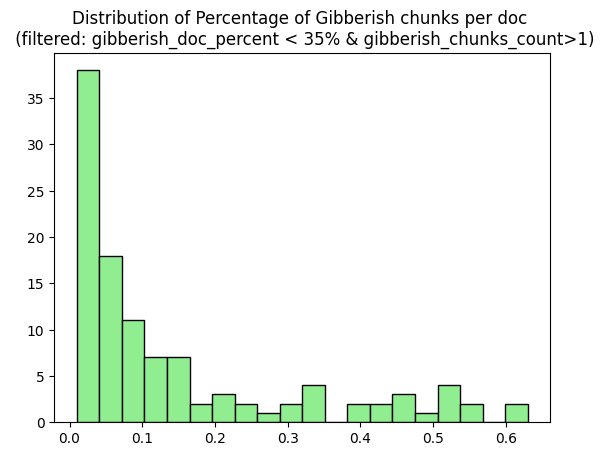

In [109]:
import matplotlib.pyplot as plt

# plot to see the % distribution ofgibberish chunks documents which have more than 35% page classifed as gibberish

print("Total docs having atleast 5 percentage of  chunk classified as gibberish:", len(df.query('gibberish_chunks_percent > 0.05')))
plt.hist(df.query('gibberish_doc_percent < 0.35').query('gibberish_chunks_count >1').gibberish_chunks_percent, color='lightgreen', ec='black', bins=20)
plt.title("Distribution of Percentage of Gibberish chunks per doc \n (filtered: gibberish_doc_percent < 35% & gibberish_chunks_count>1)")
plt.show()